In [0]:
!git clone -l -s -b master git://github.com/srgynmv/EmoteNN.git emotenn
%cd emotenn

Cloning into 'emotenn'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 317 (delta 9), reused 14 (delta 5), pack-reused 297
Receiving objects: 100% (317/317), 541.74 KiB | 15.48 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/content/emotenn


In [0]:
%tensorflow_version 2.x
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from emotenn import constants as ct, load_utils as lu, train_utils as tu, plot_utils as pu, gen_utils as gu

from sklearn.model_selection import train_test_split
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras import callbacks
from keras.models import load_model, model_from_json
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ZeroPadding2D, Convolution2D
from keras.regularizers import l2
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

!pip install keras_vggface
from keras_vggface.vggface import VGGFace

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


## Generate the dataset

In [0]:
lu.download_file_from_google_drive(ct.FER_ARCHIVE, exist_ok=True)
gu.unpack(ct.FER_ARCHIVE.path)

In [0]:
FER_CSV_PATH = os.path.join(ct.UNPACKED_DIR, 'fer2013', 'fer2013.csv')
FER_WIDTH = 48
FER_HEIGHT = 48

data = pd.read_csv(FER_CSV_PATH)

TARGET_DIR = os.path.join(ct.DATASETS_DIR, 'fer2013_images')

for class_name in ct.CLASS_NAMES:
        os.makedirs(os.path.join(TARGET_DIR, class_name), exist_ok=True)

for index, row in data.iterrows():
    image = [int(pixel) for pixel in row['pixels'].split(' ')]
    image = np.asarray(image, dtype=np.float32).reshape(FER_WIDTH, FER_HEIGHT)
    path = os.path.join(TARGET_DIR, ct.CLASS_NAMES[int(row['emotion'])], f'{index:05}.png')
    plt.imsave(path, image, cmap='gray')

## Train model

In [0]:
strategy = tu.get_distribution_strategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
def build_model():
    #with strategy.scope():
    with tf.device('GPU:0'):
        vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
        last_layer = vgg_notop.get_layer('avg_pool').output
        x = Flatten(name='flatten')(last_layer)
        x = Dense(4096, activation='relu', name='fc6')(x)
        x = Dense(1024, activation='relu', name='fc7')(x)
        for i in range(101):
            vgg_notop.layers[i].trainable = False

        out = Dense(7, activation='softmax', name='classifier')(x)
        custom_resnet = Model(vgg_notop.input, out)
        custom_resnet.compile(optimizer='sgd',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
        #print(custom_resnet.summary())
        return custom_resnet

In [0]:
def get_callbacks(model_name):
    path = os.path.join(ct.CHECKPOINTS_DIR, model_name + '-{epoch:02d}-{val_accuracy:.2f}.h5')
    os.makedirs(ct.CHECKPOINTS_DIR, exist_ok=True)

#    early_stopping = callbacks.EarlyStopping(verbose=1, patience=10, monitor='val_accuracy', mode='max')
    plateau = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='max',
                                                epsilon=0.0001, cooldown=0, min_lr=0)
    checkpoint = callbacks.ModelCheckpoint(path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    return [plateau, checkpoint]

In [0]:
batch_size = 32
data_gen = ImageDataGenerator(validation_split=0.15)
train_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='training')
valid_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='validation')

Found 30507 images belonging to 7 classes.
Found 5380 images belonging to 7 classes.


In [0]:
epochs = 10
cb = get_callbacks('resnet')

model = build_model()
train_history = model.fit(x=train_data,
                          steps_per_epoch=train_data.samples // train_data.batch_size,
                          validation_data=valid_data,
                          validation_steps=valid_data.samples // valid_data.batch_size,
                          callbacks=cb,
                          epochs=epochs)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/10
953/953 [==============================] - 551s 578ms/step - loss: 1.0150 - accuracy: 0.6287 - val_loss: 1.1684 - val_accuracy: 0.6363

Epoch 00001: val_accuracy improved from -inf to 0.63635, saving model to /content/emotenn/results/checkpoints/resnet-01-0.64.h5
Epoch 2/10
953/953 [==============================] - 546s 573ms/step - loss: 0.7058 - accuracy: 0.7414 - val_loss: 1.0479 - val_accuracy: 0.6202

Epoch 00002: val_accuracy did not improve from 0.63635
Epoch 3/10
953/953 [==============================] - 546s 573ms/step - loss: 0.5172 - accuracy: 0.8124 - val_loss: 1.5175 - val_accuracy: 0.6253

Epoch 00003: val_accuracy did not improve from 0.63635
Epoch 4/10
953/953 [==============================] - 546s 572ms/step - loss: 0.3589 - accuracy: 0.8717 - val_loss: 1.5526 - val_accuracy: 0.6294

Epoch 00004: val_accuracy did not improve from 0.63635
Epoch 5/10
953/953 [==============================] - 546s 573ms/step - loss: 0.2523 - accuracy: 0.9139 - val_loss: 1.4

## Evaluate the model

169/169 [==============================] - 54s 322ms/step
Dataset accuracy: 59.61%


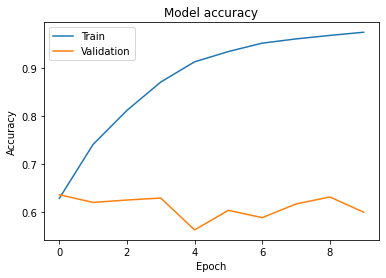

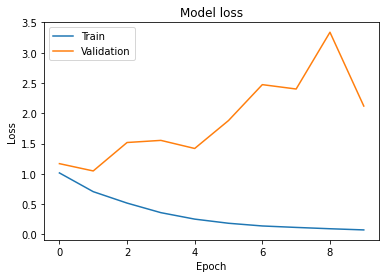

In [0]:
score = model.evaluate(x=valid_data)
print("Dataset {}: {:.2f}%".format(model.metrics_names[1], score[1] * 100))
pu.plot_model_history(train_history.history)

In [0]:
test_data = data_gen.flow_from_directory(TARGET_DIR,
                                         classes=ct.CLASS_NAMES,
                                         target_size=(224, 224),
                                         batch_size=batch_size,
                                         subset='validation',
                                         shuffle=False)

Found 5380 images belonging to 7 classes.


In [0]:
predictions = model.predict_generator(test_data)
Y_pred = np.rint(predictions)
Y_true = test_data.classes

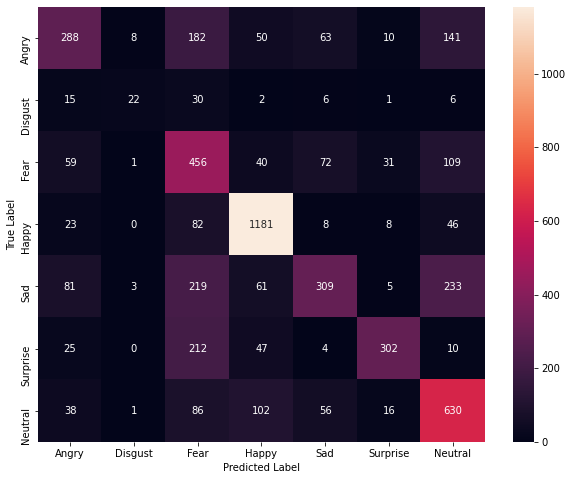

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_mtx = confusion_matrix(Y_true, np.argmax(Y_pred, axis=1)) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=ct.CLASS_NAMES, yticklabels=ct.CLASS_NAMES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Use image data generator to produce augmented images

In [0]:
batch_size = 256
data_gen = ImageDataGenerator(validation_split=0.15,
                              rotation_range=15,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              horizontal_flip=True,
                              zoom_range=0.2)
train_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='training')
valid_data = data_gen.flow_from_directory(TARGET_DIR,
                                          classes=ct.CLASS_NAMES,
                                          target_size=(224, 224),
                                          batch_size=batch_size,
                                          subset='validation')

Found 30507 images belonging to 7 classes.
Found 5380 images belonging to 7 classes.


In [0]:
epochs = 10
cb = get_callbacks('resnet-augmented')

model_augmented = build_model()
train_history = model_augmented.fit(x=train_data,
                                    steps_per_epoch=train_data.samples // train_data.batch_size,
                                    validation_data=valid_data,
                                    validation_steps=valid_data.samples // valid_data.batch_size,
                                    callbacks=cb,
                                    epochs=epochs)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/10
119/119 [==============================] - 316s 3s/step - loss: 1.3440 - accuracy: 0.5331 - val_loss: 1.3111 - val_accuracy: 0.5541

Epoch 00001: val_accuracy improved from -inf to 0.55413, saving model to /content/emotenn/results/checkpoints/resnet-augmented-01-0.55.h5
Epoch 2/10
119/119 [==============================] - 327s 3s/step - loss: 0.9395 - accuracy: 0.6495 - val_loss: 1.2992 - val_accuracy: 0.5468

Epoch 00002: val_accuracy did not improve from 0.55413
Epoch 3/10
119/119 [==============================] - 324s 3s/step - loss: 0.8488 - accuracy: 0.6850 - val_loss: 1.0388 - val_accuracy: 0.5970

Epoch 00003: val_accuracy improved from 0.55413 to 0.59699, saving model to /content/emotenn/results/checkpoints/resnet-augmented-03-0.60.h5
Epoch 4/10
119/119 [==============================] - 320s 3s/step - loss: 0.7768 - accuracy: 0.7136 - val_loss: 1.1240 - val_accuracy: 0.6050

Epoch 00004: val_accuracy improved from 0.59699 to 0.60500, saving model to /content/emote

## Evaluate the second model

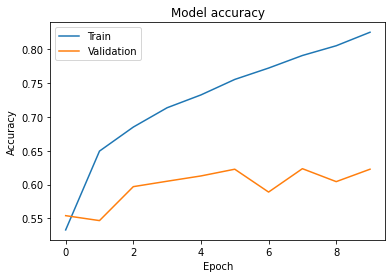

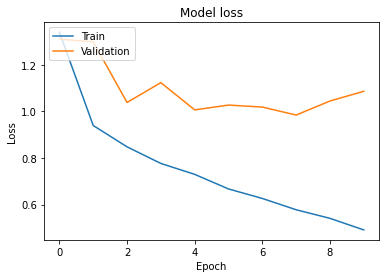

In [0]:
pu.plot_model_history(train_history.history)

## Make proper validation split

In [0]:
batch_size = 256
val_split = 0.15
seed = np.random.randint(1000)

train_data_gen = ImageDataGenerator(validation_split=val_split,
                                    rotation_range=15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    zoom_range=0.2)

train_data = train_data_gen.flow_from_directory(TARGET_DIR,
                                                classes=ct.CLASS_NAMES,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                subset='training',
                                                seed=seed)

valid_data_gen = ImageDataGenerator(validation_split=val_split)

valid_data = valid_data_gen.flow_from_directory(TARGET_DIR,
                                                classes=ct.CLASS_NAMES,
                                                target_size=(224, 224),
                                                batch_size=batch_size,
                                                subset='validation',
                                                seed=seed)

Found 30507 images belonging to 7 classes.
Found 5380 images belonging to 7 classes.


In [0]:
epochs = 10
cb = get_callbacks('resnet-augmented-valid')

model_augmented = build_model()
train_history = model_augmented.fit(x=train_data,
                                    steps_per_epoch=train_data.samples // train_data.batch_size,
                                    validation_data=valid_data,
                                    validation_steps=valid_data.samples // valid_data.batch_size,
                                    callbacks=cb,
                                    epochs=epochs)

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/10
119/119 [==============================] - 375s 3s/step - loss: 1.3160 - accuracy: 0.5315 - val_loss: 1.0461 - val_accuracy: 0.5696

Epoch 00001: val_accuracy improved from -inf to 0.56957, saving model to /content/emotenn/results/checkpoints/resnet-augmented-valid-01-0.57.h5
Epoch 2/10
119/119 [==============================] - 354s 3s/step - loss: 0.9386 - accuracy: 0.6489 - val_loss: 0.9789 - val_accuracy: 0.6038

Epoch 00002: val_accuracy improved from 0.56957 to 0.60383, saving model to /content/emotenn/results/checkpoints/resnet-augmented-valid-02-0.60.h5
Epoch 3/10
119/119 [==============================] - 350s 3s/step - loss: 0.8414 - accuracy: 0.6875 - val_loss: 1.0960 - val_accuracy: 0.6204

Epoch 00003: val_accuracy improved from 0.60383 to 0.62041, saving model to /content/emotenn/results/checkpoints/resnet-augmented-valid-03-0.62.h5
Epoch 4/10
119/119 [==============================] - 349s 3s/step - loss: 0.7763 - accuracy: 0.7152 - val_loss: 1.0094 - val_accu

Train for 10 more epochs

In [0]:
train_history = model_augmented.fit(x=train_data,
                                    steps_per_epoch=train_data.samples // train_data.batch_size,
                                    validation_data=valid_data,
                                    validation_steps=valid_data.samples // valid_data.batch_size,
                                    callbacks=cb,
                                    epochs=20,
                                    initial_epoch=10)

Epoch 11/20
119/119 [==============================] - 351s 3s/step - loss: 0.4486 - accuracy: 0.8411 - val_loss: 0.9198 - val_accuracy: 0.6455

Epoch 00011: val_accuracy did not improve from 0.64578
Epoch 12/20
119/119 [==============================] - 349s 3s/step - loss: 0.4124 - accuracy: 0.8533 - val_loss: 0.8915 - val_accuracy: 0.6423

Epoch 00012: val_accuracy did not improve from 0.64578
Epoch 13/20
119/119 [==============================] - 346s 3s/step - loss: 0.3729 - accuracy: 0.8695 - val_loss: 1.1283 - val_accuracy: 0.6274

Epoch 00013: val_accuracy did not improve from 0.64578
Epoch 14/20
119/119 [==============================] - 346s 3s/step - loss: 0.3571 - accuracy: 0.8763 - val_loss: 1.1320 - val_accuracy: 0.6432

Epoch 00014: val_accuracy did not improve from 0.64578
Epoch 15/20
119/119 [==============================] - 344s 3s/step - loss: 0.3214 - accuracy: 0.8916 - val_loss: 1.1200 - val_accuracy: 0.6415

Epoch 00015: val_accuracy did not improve from 0.64578


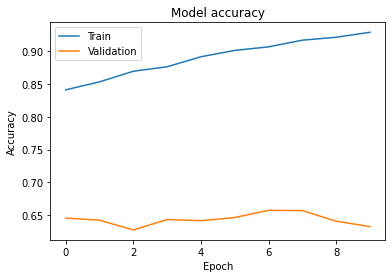

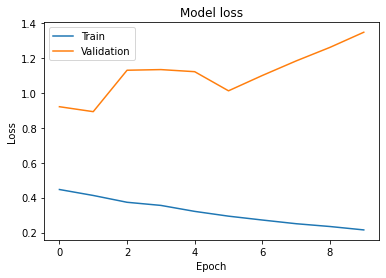

In [0]:
pu.plot_model_history(train_history.history)

In [0]:
test_data = valid_data_gen.flow_from_directory(TARGET_DIR,
                                               classes=ct.CLASS_NAMES,
                                               target_size=(224, 224),
                                               batch_size=batch_size,
                                               subset='validation',
                                               shuffle=False)

Found 5380 images belonging to 7 classes.


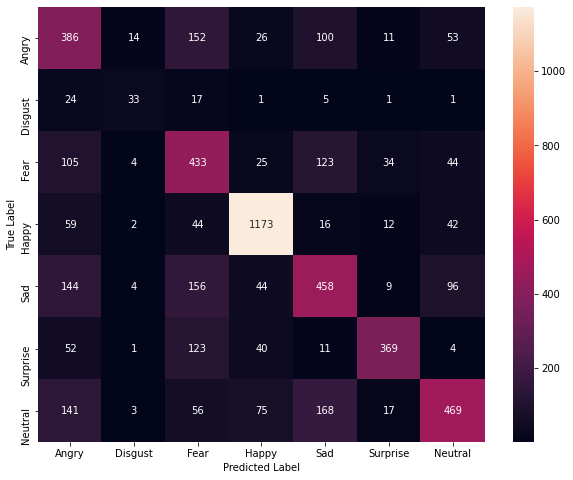

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = model_augmented.predict_generator(test_data)
Y_pred = np.rint(predictions)
Y_true = test_data.classes
confusion_mtx = confusion_matrix(Y_true, np.argmax(Y_pred, axis=1)) 
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', xticklabels=ct.CLASS_NAMES, yticklabels=ct.CLASS_NAMES)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

10 more epochs...

In [110]:
train_history = model_augmented.fit(x=train_data,
                                    steps_per_epoch=train_data.samples // train_data.batch_size,
                                    validation_data=valid_data,
                                    validation_steps=valid_data.samples // valid_data.batch_size,
                                    callbacks=cb,
                                    epochs=30,
                                    initial_epoch=20)

Epoch 21/30
119/119 [==============================] - 354s 3s/step - loss: 0.1968 - accuracy: 0.9359 - val_loss: 1.3581 - val_accuracy: 0.6562

Epoch 00021: val_accuracy did not improve from 0.65730
Epoch 22/30
119/119 [==============================] - 352s 3s/step - loss: 0.1929 - accuracy: 0.9378 - val_loss: 1.1151 - val_accuracy: 0.6450

Epoch 00022: val_accuracy did not improve from 0.65730
Epoch 23/30
119/119 [==============================] - 350s 3s/step - loss: 0.1826 - accuracy: 0.9412 - val_loss: 1.2025 - val_accuracy: 0.6591

Epoch 00023: val_accuracy improved from 0.65730 to 0.65906, saving model to /content/emotenn/results/checkpoints/resnet-augmented-valid-23-0.66.h5
Epoch 24/30
119/119 [==============================] - 345s 3s/step - loss: 0.1696 - accuracy: 0.9451 - val_loss: 1.2425 - val_accuracy: 0.6497

Epoch 00024: val_accuracy did not improve from 0.65906
Epoch 25/30
119/119 [==============================] - 343s 3s/step - loss: 0.1663 - accuracy: 0.9463 - val_